# Exercise Model

## Requirement

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

## Data Preparation

In [3]:
df_cal = pd.read_csv('/content/calories.csv')
df_ex = pd.read_csv('/content/exercise.csv')

In [4]:
df_cal

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0
...,...,...
14995,15644082,45.0
14996,17212577,23.0
14997,17271188,75.0
14998,18643037,11.0


In [5]:
df_ex

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8
...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3


In [6]:
# merge
df = pd.merge(df_ex, df_cal, on = 'User_ID')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [7]:
df.dtypes

User_ID         int64
Gender         object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

In [8]:
df['Gender'] = pd.get_dummies(df['Gender'], prefix_sep='_', drop_first=True)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Gender        0.022357
Height        0.017537
Name: Calories, dtype: float64


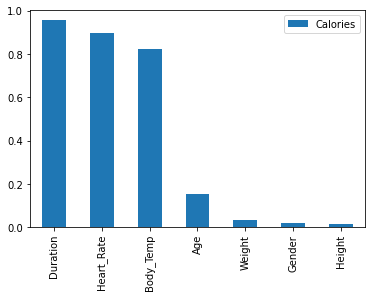

In [9]:
# correlations with calories
correlations = df.drop(columns=['User_ID'],axis=1).copy().corr()['Calories']
correlations = correlations.sort_values(ascending=False).drop('Calories',axis=0)
print(correlations)
correlations.to_frame().plot.bar();

In [10]:
df_7f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Gender','Height','Calories']].copy()
df_7f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

df_5f = df[['Duration','Age','Weight','Gender','Height','Calories']].copy()
df_5f.rename(columns={'Duration':'t',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

In [11]:
# train test split
X_7 = df_7f[['t','h','T','A','W','G','H']]
y_7 = df_7f['C']
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, test_size=0.2, random_state=21)

X_5 = df_5f[['t','A','W','G','H']]
y_5 = df_5f['C']
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=21)

In [12]:
scaler = StandardScaler()

X_train_7 = scaler.fit_transform(X_train_7)
X_test_7 = scaler.transform(X_test_7)

X_train_5 = scaler.fit_transform(X_train_5)
X_test_5 = scaler.transform(X_test_5)

## Modeling

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7)

In [14]:
model_7 = keras.Sequential([
    keras.layers.Dense(X_7.shape[1], activation='relu', input_dim = X_7.shape[1]), # input
    keras.layers.Dense(512, kernel_initializer='normal', activation='relu'), # beginning of hidden layer
    keras.layers.Dense(512, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(256, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(32, kernel_initializer='normal', activation='relu'), # end of hidden layer
    keras.layers.Dense(1, kernel_initializer='normal', activation='relu') # output
])

In [15]:
model_7.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse','mae'])
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 512)               4096      
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2

In [16]:
history_7 = model_7.fit(X_train_7, y_train_7.to_numpy(), batch_size = 16, epochs = 50, callbacks=[callback], verbose = 1)

Epoch 1/50
750/750 [==============================] - 8s 9ms/step - loss: 615.6537 - mse: 615.6537 - mae: 13.3831
Epoch 2/50
750/750 [==============================] - 7s 9ms/step - loss: 47.3574 - mse: 47.3574 - mae: 5.3329
Epoch 3/50
750/750 [==============================] - 10s 13ms/step - loss: 24.6254 - mse: 24.6254 - mae: 3.8386
Epoch 4/50
750/750 [==============================] - 10s 14ms/step - loss: 16.0792 - mse: 16.0792 - mae: 3.0581
Epoch 5/50
750/750 [==============================] - 10s 14ms/step - loss: 9.3982 - mse: 9.3982 - mae: 2.3339
Epoch 6/50
750/750 [==============================] - 7s 10ms/step - loss: 7.8425 - mse: 7.8425 - mae: 2.0751
Epoch 7/50
750/750 [==============================] - 7s 9ms/step - loss: 6.7016 - mse: 6.7016 - mae: 1.9086
Epoch 8/50
750/750 [==============================] - 8s 10ms/step - loss: 6.4684 - mse: 6.4684 - mae: 1.8256
Epoch 9/50
750/750 [==============================] - 7s 9ms/step - loss: 5.0341 - mse: 5.0341 - mae: 1.6623


In [17]:
model_5 = keras.Sequential([
    keras.layers.Dense(X_5.shape[1], activation='relu', input_dim = X_5.shape[1]), # input
    keras.layers.Dense(512, kernel_initializer='normal', activation='relu'), # beginning of hidden layer
    keras.layers.Dense(512, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(256, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(32, kernel_initializer='normal', activation='relu'), # end of hidden layer
    keras.layers.Dense(1, kernel_initializer='normal', activation='relu') # output
])

In [18]:
model_5.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse','mae'])
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dense_9 (Dense)             (None, 512)               3072      
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)               

In [19]:
history_5 = model_5.fit(X_train_5, y_train_5.to_numpy(), batch_size = 16, epochs = 50, callbacks=[callback], verbose = 1)

Epoch 1/50
750/750 [==============================] - 11s 13ms/step - loss: 1524.2131 - mse: 1524.2131 - mae: 24.5057
Epoch 2/50
750/750 [==============================] - 7s 10ms/step - loss: 244.1519 - mse: 244.1519 - mae: 11.1757
Epoch 3/50
750/750 [==============================] - 8s 10ms/step - loss: 198.5211 - mse: 198.5211 - mae: 10.0722
Epoch 4/50
750/750 [==============================] - 7s 10ms/step - loss: 184.8819 - mse: 184.8819 - mae: 9.7726
Epoch 5/50
750/750 [==============================] - 7s 9ms/step - loss: 170.2497 - mse: 170.2497 - mae: 9.3876
Epoch 6/50
750/750 [==============================] - 7s 9ms/step - loss: 164.9631 - mse: 164.9631 - mae: 9.1901
Epoch 7/50
750/750 [==============================] - 7s 10ms/step - loss: 167.7592 - mse: 167.7592 - mae: 9.2024
Epoch 8/50
750/750 [==============================] - 8s 11ms/step - loss: 166.9539 - mse: 166.9539 - mae: 9.1988
Epoch 9/50
750/750 [==============================] - 7s 10ms/step - loss: 159.7593 

In [20]:
y_pred_7 = model_7.predict(X_test_7)
y_pred_5 = model_5.predict(X_test_5)

In [21]:
model_7.evaluate(X_test_7, y_test_7)

94/94 [==============================] - 0s 3ms/step - loss: 1.9134 - mse: 1.9134 - mae: 1.0051


[1.9134217500686646, 1.9134217500686646, 1.0051220655441284]

In [22]:
model_5.evaluate(X_test_5, y_test_5)

94/94 [==============================] - 0s 3ms/step - loss: 135.6219 - mse: 135.6219 - mae: 8.1575


[135.62188720703125, 135.62188720703125, 8.157508850097656]

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['mae'], label='mae')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Calories]')
  plt.legend()
  plt.grid(True)

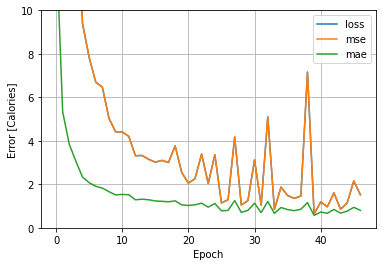

In [24]:
plot_loss(history_7)

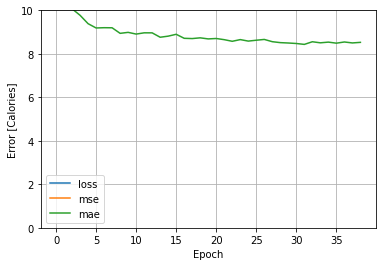

In [25]:
plot_loss(history_5)

In [26]:
model_7.save('model_7.h5')

In [27]:
model_5.save('model_5.h5')